In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import os
os.listdir(os.path.join(os.getcwd(), "dataset/random"))

['glass', 'metal', 'paper', 'plastic', 'trash']

In [3]:
from pathlib import Path
data_dir = Path(os.getcwd())/"dataset/random"
data_dir

WindowsPath('D:/Recycling_Keras/dataset/random')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

8992


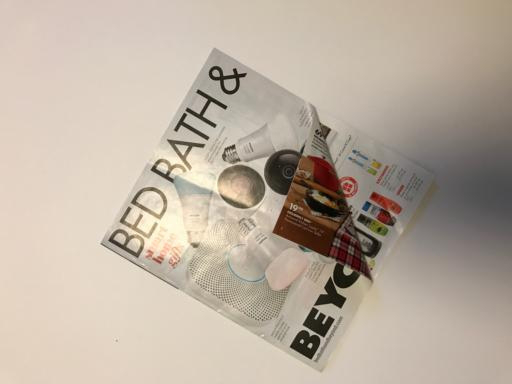

In [5]:
papers = list(data_dir.glob('paper/*'))
PIL.Image.open(str(papers[0]))

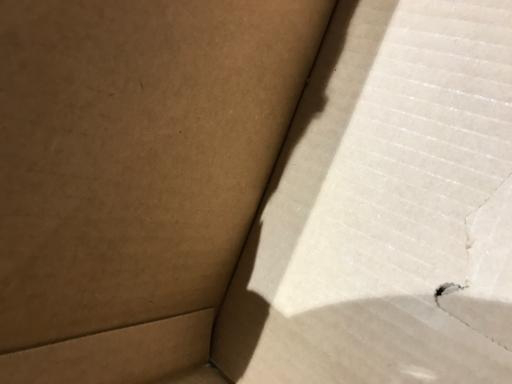

In [6]:
PIL.Image.open(str(papers[1]))

In [7]:
batch_size = 20
img_height = 384
img_width = 512

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8992 files belonging to 5 classes.
Using 7194 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8992 files belonging to 5 classes.
Using 1798 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['glass', 'metal', 'paper', 'plastic', 'trash']


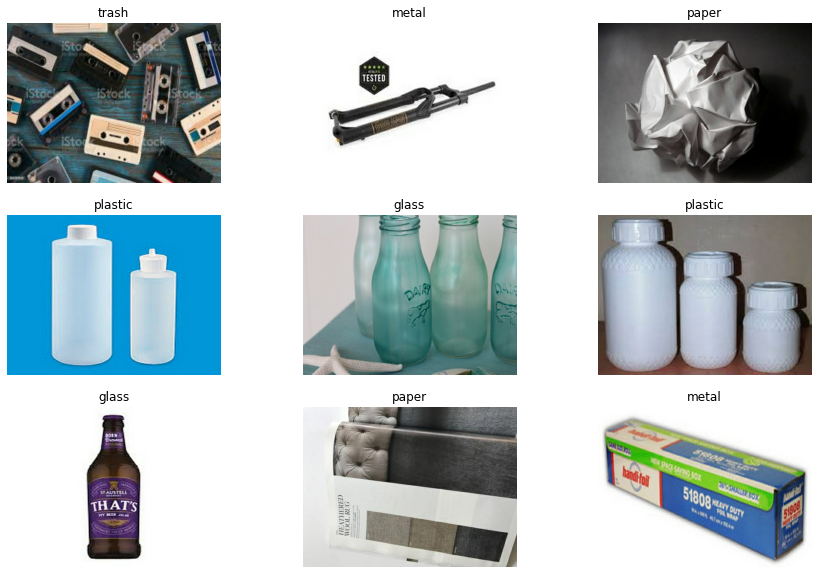

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(20, 384, 512, 3)
(20,)


In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [16]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 384, 512, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 384, 512, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 192, 256, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 128, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 128, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 64, 64)        0

In [ ]:
epochs=11
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/11
360/360 [==============================] - 391s 1s/step - loss: 2.1816 - accuracy: 0.3355 - val_loss: 1.4771 - val_accuracy: 0.3849
Epoch 2/11
141/360 [==========>...................] - ETA: 3:39 - loss: 1.3669 - accuracy: 0.4435

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('D:/Recycling_Keras/model/thousand_ver4.h5')

In [ ]:
from keras.models import load_model
model = load_model('D:/Recycling_Keras/model/thousand_ver4.h5')

In [ ]:
test_path = "D:/Recycling_Keras/sample/paper1"
img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

image = plt.imread(test_path)
plt.imshow(image)
plt.show()

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)